In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [23]:
diabetes = pd.read_csv('/content/drive/MyDrive/Decision Tree/diabetes.csv')

In [48]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [24]:
diabetes_feature = list(diabetes.columns)[:-1]
diabetes_target = list(diabetes.columns)[-1:]

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [14]:
# 트리 시각화를 위한 모듈 import
!pip install pydot

import pydot
from IPython.core.display import Image 

In [34]:
x = np.array(diabetes[diabetes_feature])
y = np.array(diabetes[diabetes_target])

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 111)

In [39]:
DTC = DecisionTreeClassifier(random_state = 111)
Tree = DTC.fit(x_train, y_train)

In [44]:
def draw_decision_tree(clf, feature_names = None, class_names = None):
    dot_data = export_graphviz(clf, out_file = None, 
                                feature_names = feature_names,
                                class_names = class_names,
                                filled = True, 
                                rounded = True,
                                special_characters = True)
    graph = pydot.graph_from_dot_data(dot_data)[0]
    image = graph.create_png()
    return Image(image)

In [49]:
draw_decision_tree(Tree, diabetes_feature, ['0','1'])

Output hidden; open in https://colab.research.google.com to view.

In [51]:
scoring = ['f1','precision','recall']
tree_scores = cross_validate(Tree, x_train, y_train, scoring=scoring, cv=5, return_train_score = False)

print("parameter가 tuning 되지 않았을 때의 F1 Score : {:.3f}".format(np.mean(tree_scores['test_f1'])))

parameter가 tuning 되지 않았을 때의 F1 Score : 0.592


In [54]:
from sklearn.model_selection import GridSearchCV

hyperparamters = {'max_depth': list(range(2, 8)),  'min_samples_split': list(range(2, 20))}

# GridSearch 진행
GridCV = GridSearchCV(estimator=Tree, param_grid=hyperparamters, cv=5, verbose=1)

GridCV.fit(x_train, y_train)
GridCV.best_params_ # 가장 좋은 성능을 보였을 때의 parameter

Fitting 5 folds for each of 108 candidates, totalling 540 fits


{'max_depth': 4, 'min_samples_split': 2}

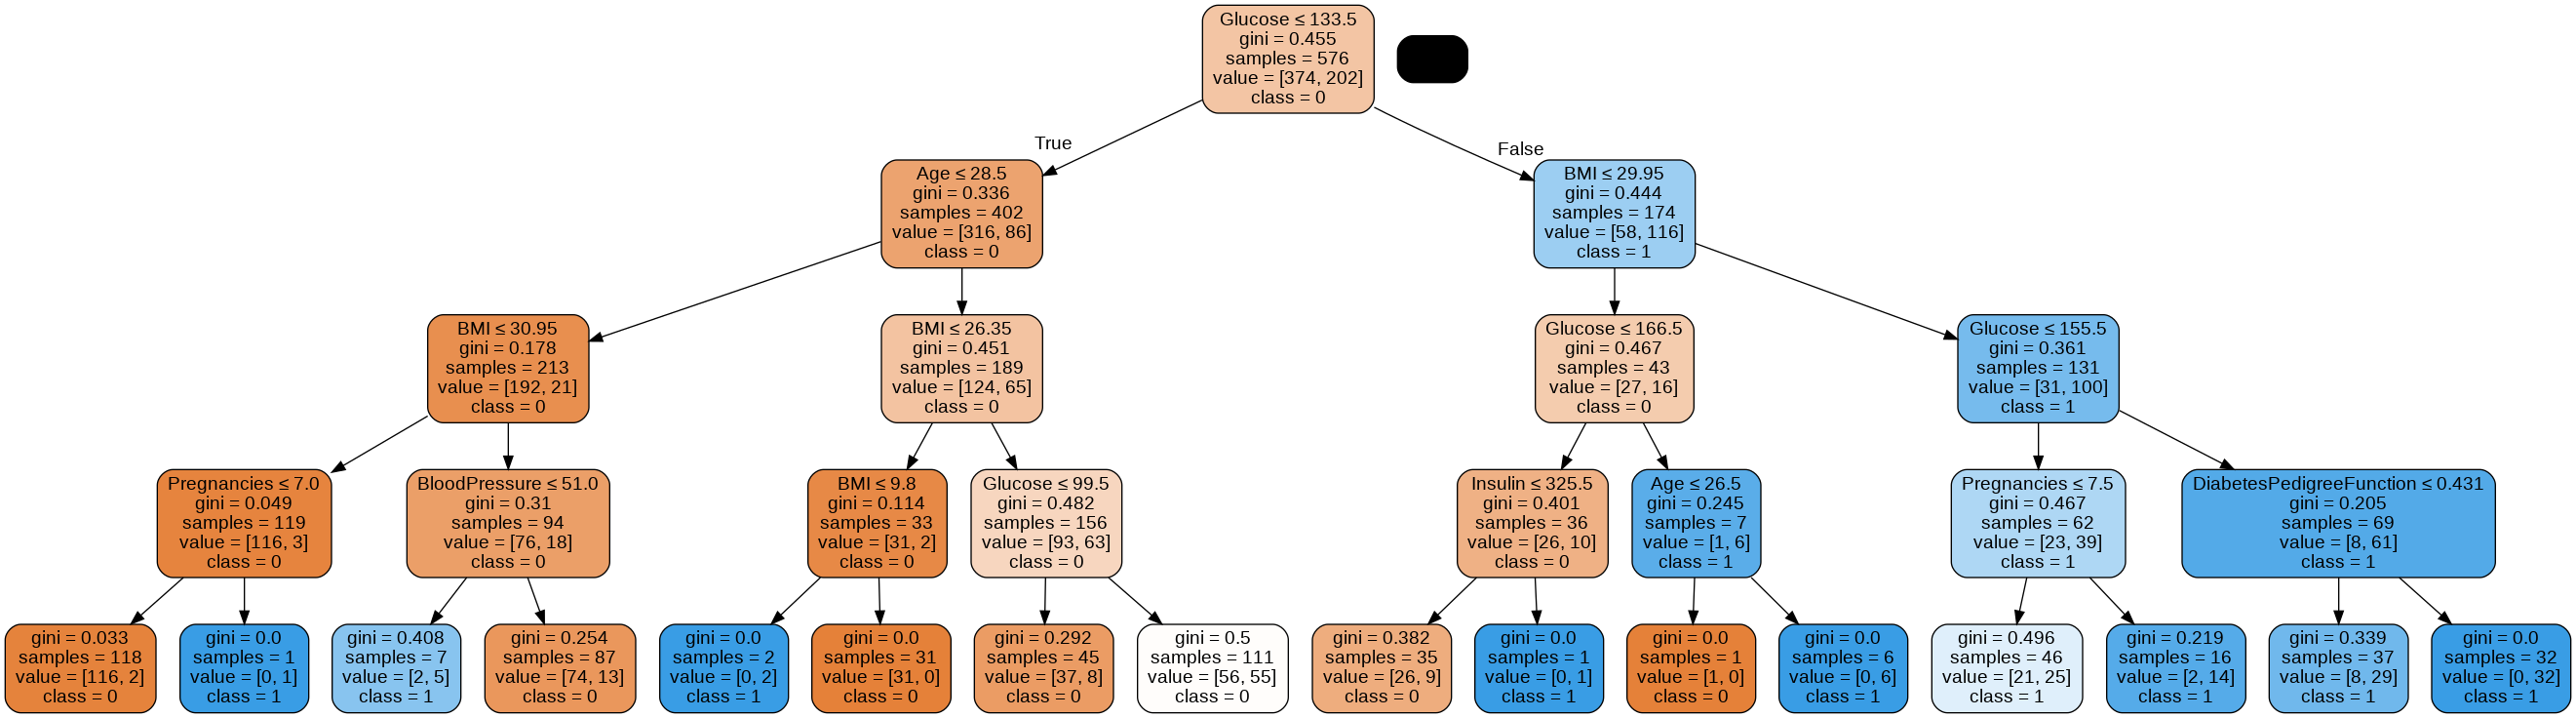

In [56]:
DTC_tuned = DecisionTreeClassifier(max_depth = 4, min_samples_split = 2, random_state = 111)
Tree_tuned = DTC_tuned.fit(x_train, y_train)

draw_decision_tree(Tree_tuned, diabetes_feature, ['0','1'])

In [59]:
tree_scores = cross_validate(Tree_tuned, x_train, y_train, scoring=scoring, cv=5, return_train_score = False)

print("parameter가 tuning 되지 않았을 때의 F1 Score : {:.3f}".format(np.mean(tree_scores['test_f1'])))

parameter가 tuning 되지 않았을 때의 F1 Score : 0.610


In [61]:
import sklearn
import matplotlib.pyplot as plt

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


In [62]:
path = DTC.cost_complexity_pruning_path(x_train, y_train)
path_tuned = DTC_tuned.cost_complexity_pruning_path(x_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas_tuned, impurities_tuned = path_tuned.ccp_alphas, path_tuned.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

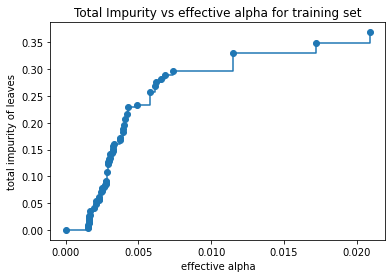

In [64]:
# effective alpha값에 따른 total impurity of leaves 그래프

fig, ax = plt.subplots()
# plt.subplots() 편의 함수는 Figure 객체를 생성하고 Figure.subplots()를 호출하여 리턴
# axes: 좌표평면을 나타내는 변수

# ccp_alphas[-1]은 노드가 하나밖에 없는 트리임.
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# alpha 값이 커지면 트리가 작아짐 -> total impurity of leaves 커짐

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

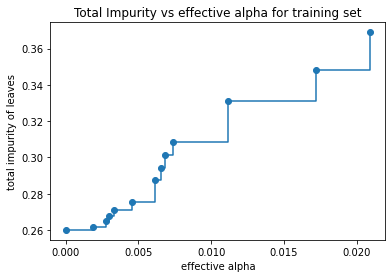

In [65]:
# effective alpha값에 따른 total impurity of leaves 그래프

fig, ax = plt.subplots()
# plt.subplots() 편의 함수는 Figure 객체를 생성하고 Figure.subplots()를 호출하여 리턴
# axes: 좌표평면을 나타내는 변수

# ccp_alphas[-1]은 노드가 하나밖에 없는 트리임.
ax.plot(ccp_alphas_tuned[:-1], impurities_tuned[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# alpha 값이 커지면 트리가 작아짐 -> total impurity of leaves 커짐

In [69]:
# effective alpha 값에 대응하는 sub-trees 시각화

clfs = []
count = 0
for ccp_alpha in ccp_alphas:
    # 각 effective alphas 이용해 decision tree 만들기
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf = clf.fit(x_train, y_train)
    count += 1
    print("Number of nodes in the {}th tree is: {} with ccp_alpha: {}".format(
      count, clf.tree_.node_count, ccp_alpha))
    display(draw_decision_tree(clf, diabetes_feature, ['0', '1']))
    clfs.append(clf)
    print("====================================================================================")

# ccp_alpha = 0 일 때는 not-pruned full tree
# ccp_alpha를 0부터 시작해서 크기를 늘려감, effective alpha를 지나면 가지치기
# 마지막에는 root node만 남음
# alpha에 따라서 subtree의 크기를 조정할 수 있음을 확인

Output hidden; open in https://colab.research.google.com to view.

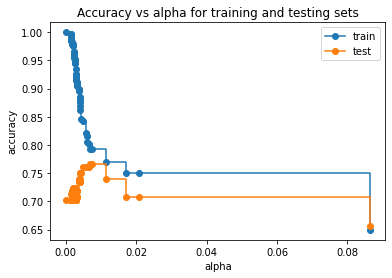

Decision tree without pruning : 207 nodes, 0.698 accuracy
Decision tree with the best pruning : 15 nodes, 0.766 accuracy


In [73]:
# testing accuracy를 높이는 최고의 ccp_alpha는?

train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

print("Decision tree without pruning : {0} nodes, {1:.3} accuracy".format(Tree.tree_.node_count, Tree.score(x_test, y_test)))
print("Decision tree with the best pruning : {0} nodes, {1:.3} accuracy".format(clfs[test_scores.index(max(test_scores))].tree_.node_count, max(test_scores)))

# 가장 높은 accuracy를 보이는 ccp_alpha 값은 약 0.013
# effective alpha = 약 0.013일 때 가장 높은 성능을 가지는 sub-tree가 만들어짐

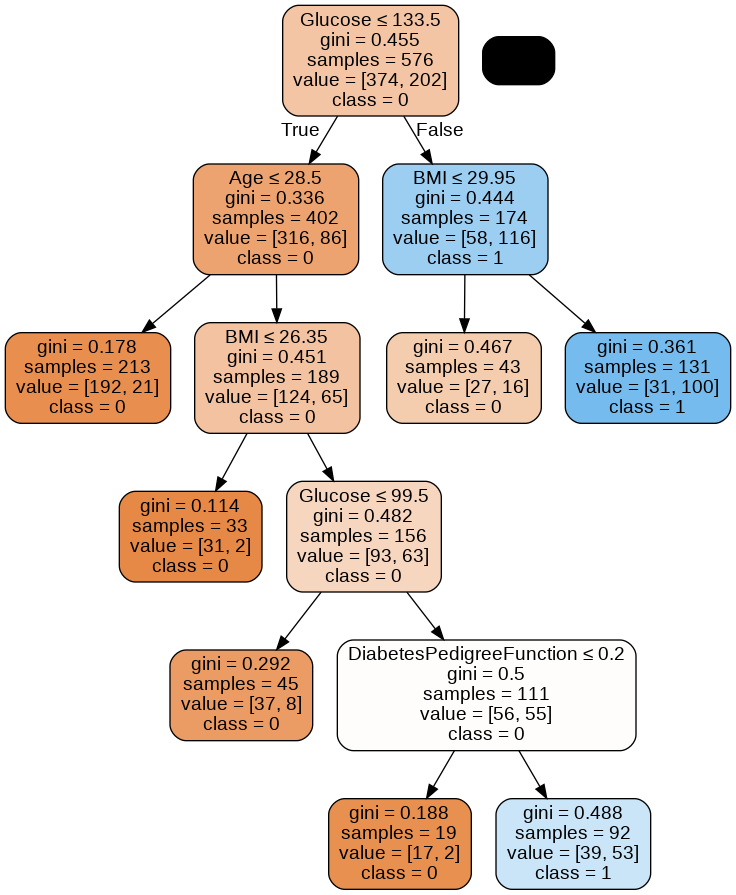

In [74]:
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.008)
clf = clf.fit(x_train, y_train)
draw_decision_tree(clf, diabetes_feature, ['0', '1'])